### 1. 数据预处理
根据地震带区域划分中国地震数据后，每一年仅保留最大震级：
- 环太平洋地震带：台湾、东海、福建、辽宁、吉林、黑龙江
- 华北地震带：北京、天津、河北、河南、山东、内蒙古、山西、陕西、江苏、安徽
- 青藏高原地震带：西藏、四川、云南、青海
- 西北地震带：新疆，甘肃、宁夏

In [1]:
from numpy import array
from pandas import read_csv
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 地震目录数据路径
io = r'./data/earthquake1970_5+.xlsx'
# 读取地震数据（年、震级、现地名）
data = pd.read_excel(io, usecols = [1, 10, 14])
data

,年,震级,现地名
0,1970,7.8,云南玉溪市通海县
1,1970,5.2,云南玉溪市红塔区
2,1970,5.5,云南玉溪市红塔区
3,1970,5.9,云南红河哈尼族彝族自治州建水县
4,1970,5.3,云南玉溪市通海县
...,...,...,...
2059,2018,6.2,台湾海峡
2060,2018,5.2,东海
2061,2018,5.7,四川宜宾市兴文县
2062,2018,5.2,新疆克孜勒苏柯尔克孜自治州阿克陶县


In [3]:
# 划分地震带
filter_data1=data[data['现地名'].str.contains('台湾')]
filter_data2=data[data['现地名'].str.contains('福建')]
filter_data3=data[data['现地名'].str.contains('东海')]
filter_data4=data[data['现地名'].str.contains('吉林')]
filter_data5=data[data['现地名'].str.contains('黑龙江')]
filter_data6=data[data['现地名'].str.contains('辽宁')]
data_ThePacificOcean=pd.concat([filter_data1,filter_data2,filter_data3,filter_data4,filter_data5,filter_data6],axis=0)
data_ThePacificOcean

,年,震级,现地名
28,1970,6.5,台湾台东县
37,1971,5.1,台湾花莲县
99,1972,7.3,台湾花莲县
100,1972,5.2,台湾花莲县
101,1972,5.2,台湾花莲县
...,...,...,...
433,1978,5.9,辽宁营口市大石桥市
435,1978,5.2,辽宁营口市大石桥市
1323,1999,5.4,辽宁鞍山市岫岩满族自治县
1327,2000,5.1,辽宁鞍山市岫岩满族自治县


In [4]:
# 按年分组后取最大值，即仅保留当年最大震级
eq_year_max = data_ThePacificOcean.groupby('年').max()
print(eq_year_max)
# 导出为csv方便使用
output_path='./data/ThePacificOcean1970-2018.csv'
eq_year_max.to_csv(output_path,sep=',',index=True,header=True)

       震级            现地名
年                       
1970  6.5          台湾台东县
1971  6.0          台湾花莲县
1972  8.0          台湾花莲县
1973  6.1          台湾苗栗县
1974  6.4          台湾花莲县
1975  7.3       辽宁鞍山市海城市
1976  6.2          台湾嘉义县
1977  6.5          台湾花莲县
1978  7.3      辽宁营口市大石桥市
1979  6.1  吉林延边朝鲜族自治州珲春市
1980  6.7          台湾宜兰县
1981  6.4          台湾宜兰县
1982  6.5          台湾花莲县
1983  6.9     黑龙江牡丹江市东宁市
1984  6.0             东海
1985  6.3             东海
1986  7.3    黑龙江黑河市五大连池市
1987  5.9  吉林延边朝鲜族自治州珲春市
1988  6.2          台湾花莲县
1989  6.7          台湾花莲县
1990  7.0          台湾花莲县
1991  6.7          台湾花莲县
1992  6.8          台湾花莲县
1993  5.9          台湾花莲县
1994  7.3       台湾高雄市内门区
1995  6.6          台湾花莲县
1996  7.1          台湾宜兰县
1997  5.4       福建龙岩市连城县
1998  6.3          台湾台东县
1999  7.6   辽宁鞍山市岫岩满族自治县
2000  6.8   辽宁鞍山市岫岩满族自治县
2001  6.4       台湾高雄市甲仙区
2002  7.5     黑龙江牡丹江市穆棱市
2003  7.0          台湾花莲县
2004  6.7          台湾花莲县
2005  6.3      黑龙江大庆市林甸县
2006  6.5       吉林松原市乾安县
2007  6.5             东海


In [5]:
# 计算震级能量值，并加入到新的列中，导出csv
data=pd.read_csv('./data/ThePacificOcean1970-2018.csv')
for i in range(0,len(data)):
    dt=data['震级'][i]
    energy=10**dt
    data.loc[i,'能量']=round(energy,2)
print(data)
data.to_csv('ThePacificOcean1970-2018.csv')

       年   震级            现地名            能量
0   1970  6.5          台湾台东县  3.162278e+06
1   1971  6.0          台湾花莲县  1.000000e+06
2   1972  8.0          台湾花莲县  1.000000e+08
3   1973  6.1          台湾苗栗县  1.258925e+06
4   1974  6.4          台湾花莲县  2.511886e+06
5   1975  7.3       辽宁鞍山市海城市  1.995262e+07
6   1976  6.2          台湾嘉义县  1.584893e+06
7   1977  6.5          台湾花莲县  3.162278e+06
8   1978  7.3      辽宁营口市大石桥市  1.995262e+07
9   1979  6.1  吉林延边朝鲜族自治州珲春市  1.258925e+06
10  1980  6.7          台湾宜兰县  5.011872e+06
11  1981  6.4          台湾宜兰县  2.511886e+06
12  1982  6.5          台湾花莲县  3.162278e+06
13  1983  6.9     黑龙江牡丹江市东宁市  7.943282e+06
14  1984  6.0             东海  1.000000e+06
15  1985  6.3             东海  1.995262e+06
16  1986  7.3    黑龙江黑河市五大连池市  1.995262e+07
17  1987  5.9  吉林延边朝鲜族自治州珲春市  7.943282e+05
18  1988  6.2          台湾花莲县  1.584893e+06
19  1989  6.7          台湾花莲县  5.011872e+06
20  1990  7.0          台湾花莲县  1.000000e+07
21  1991  6.7          台湾花莲县  5.011872e+06
22  1992  6

### 2. 读取并可视化地震震级/能量折线图

In [6]:
# 自定义读取数据
def read_data(path, col_index, col_name): 
    # path：路径
    # col_index：第几列（从0开始）
    # col_name：列名
    df = read_csv(path, usecols=[col_index], encoding='gbk')
    data = df[col_name].values
    return data

In [7]:
# 可视化四个地震带的地震震级/能量折线图
def show( d1,d2, d3, d4):   
    fig = plt.figure(figsize=(30,40))
    ax1 = fig.add_subplot(411) # “411”表示“4×1网格，第一子图”
    ax1.set_title('ThePacificOcean', fontsize=15, color='b')
    ax1.plot(d1)
    ax2 = fig.add_subplot(412)
    ax2.set_title('QinghaiTibetPlateau', fontsize=15, color='b')
    ax2.plot(d2)
    ax3 = fig.add_subplot(413)
    ax3.set_title('NorthWest', fontsize=15, color='b')
    ax3.plot(d3)
    ax4 = fig.add_subplot(414)
    ax4.set_title('NorthChina', fontsize=15, color='b')
    ax4.plot(d4)
    plt.show()

data_ThePacificOcean:51
data_QinghaiTibetPlateau:51
data_NorthWest:51
data_NorthChina:26


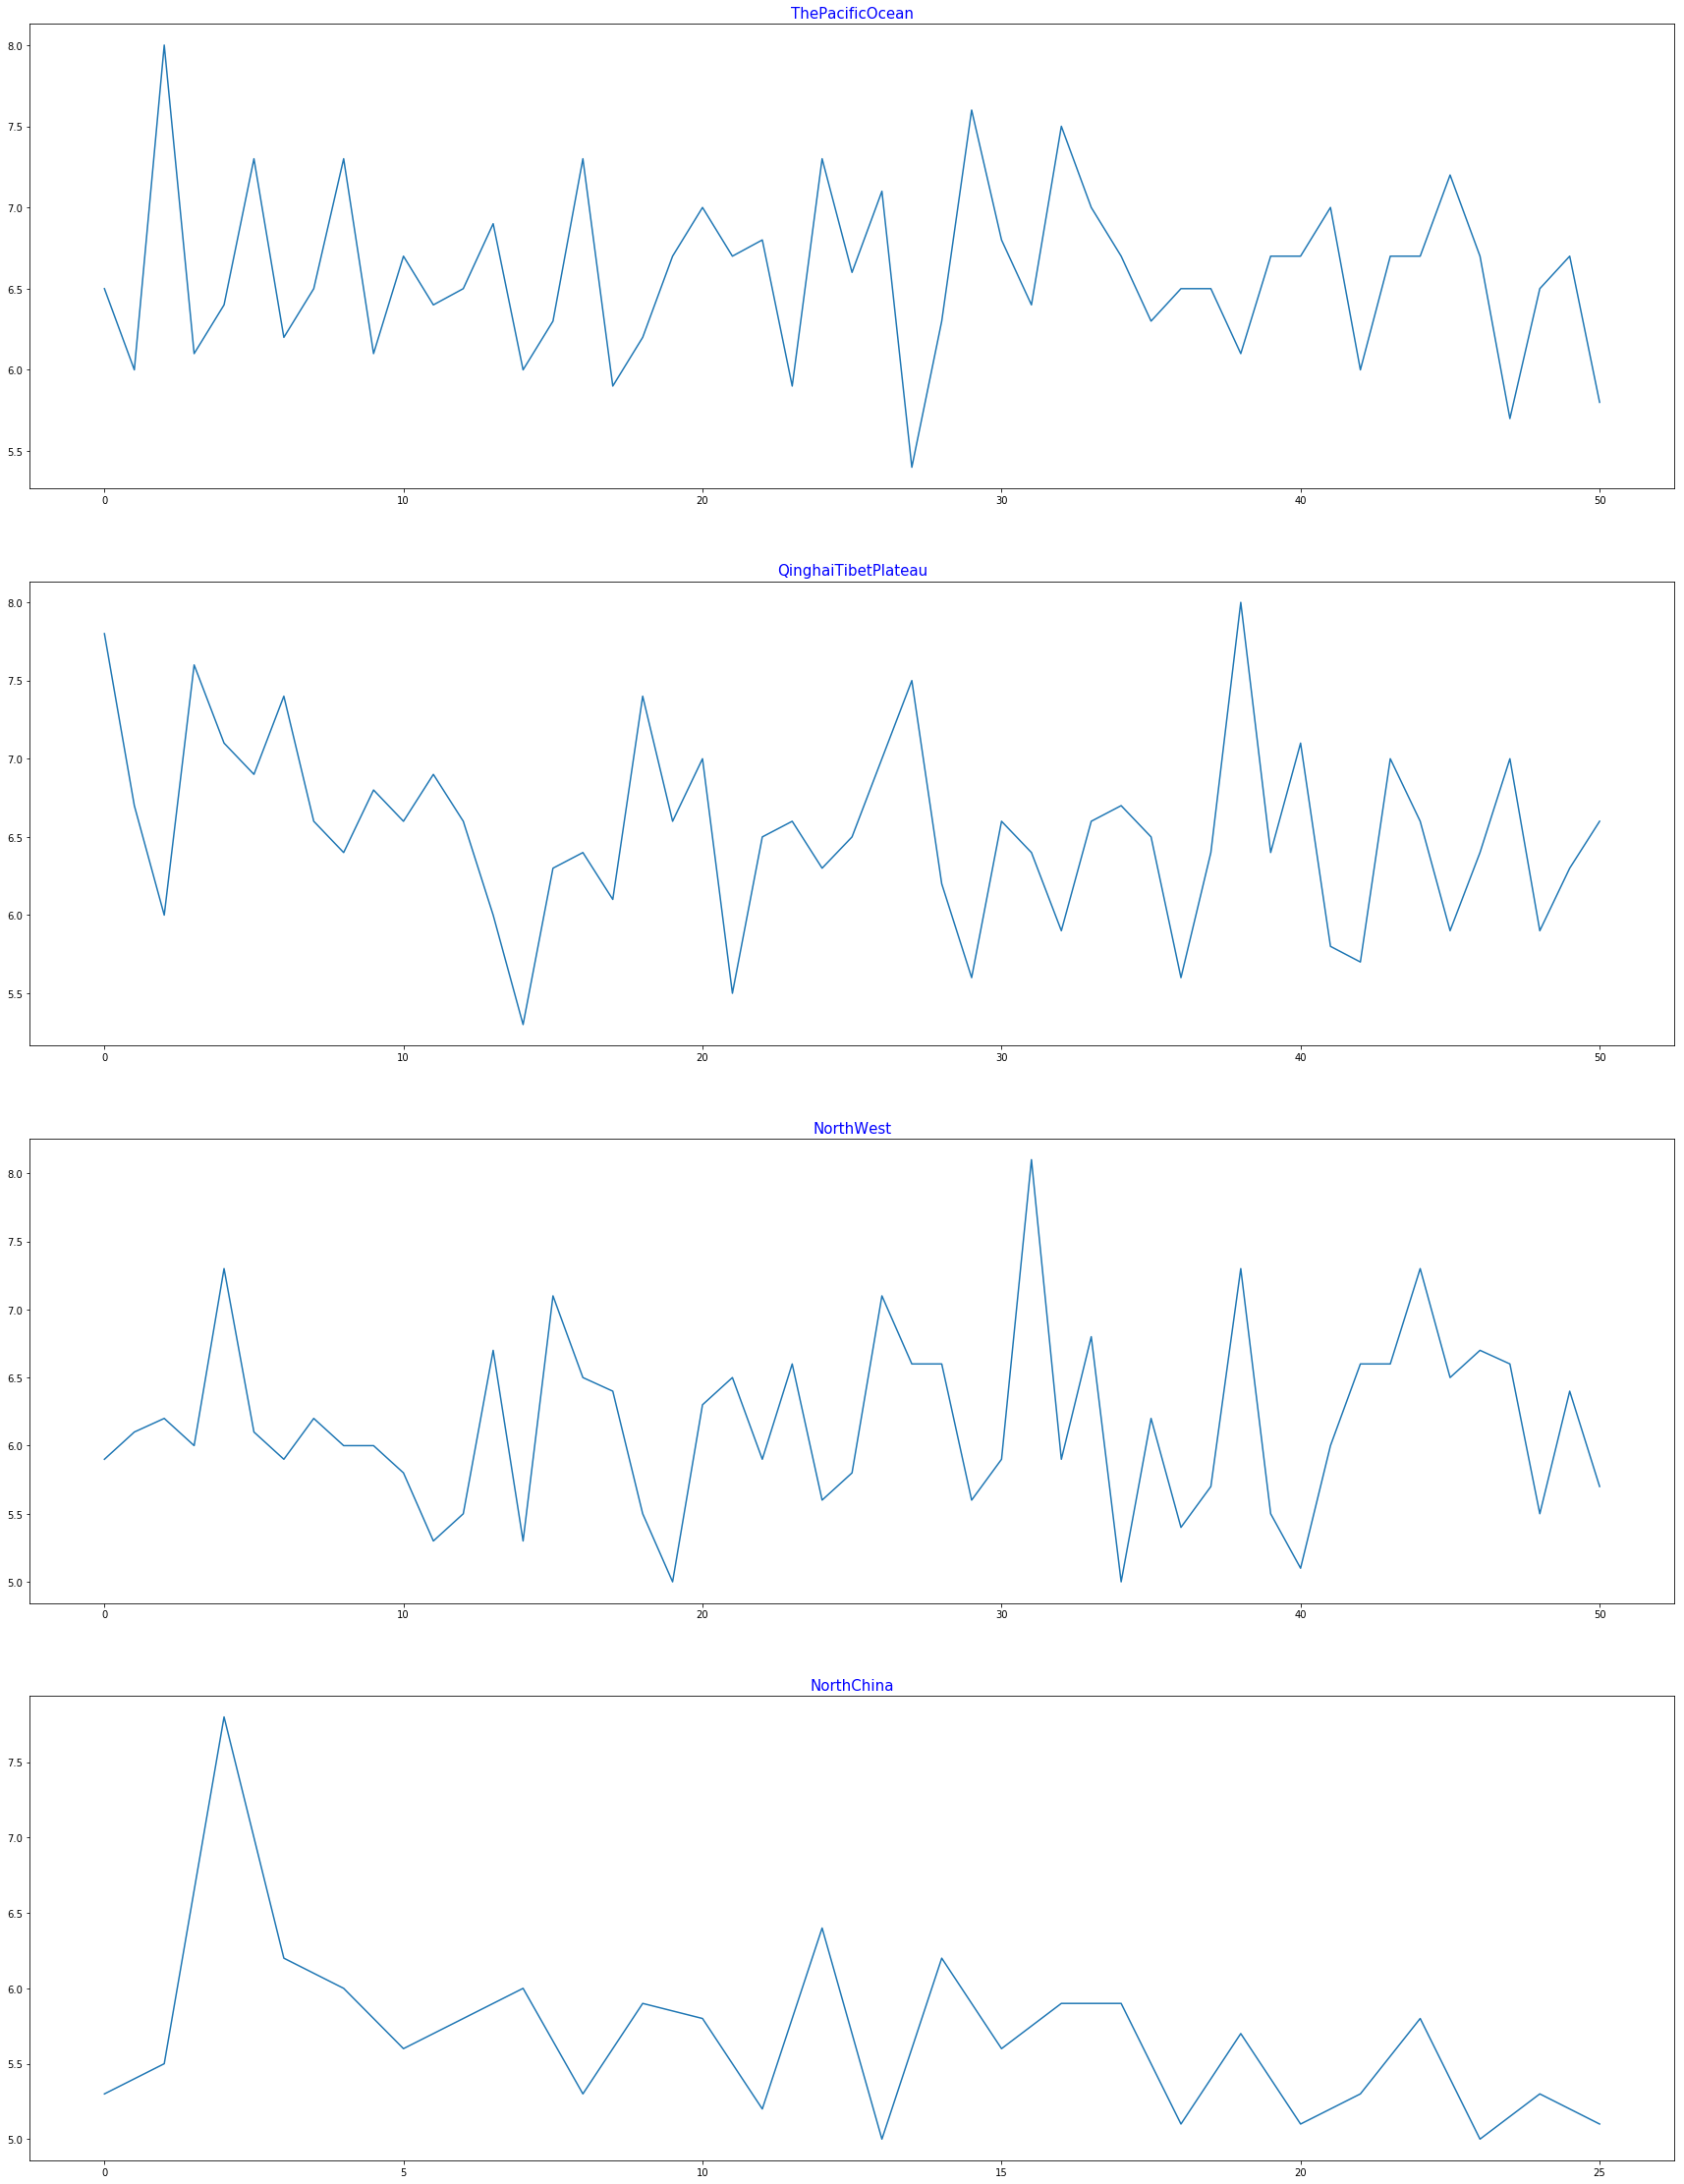

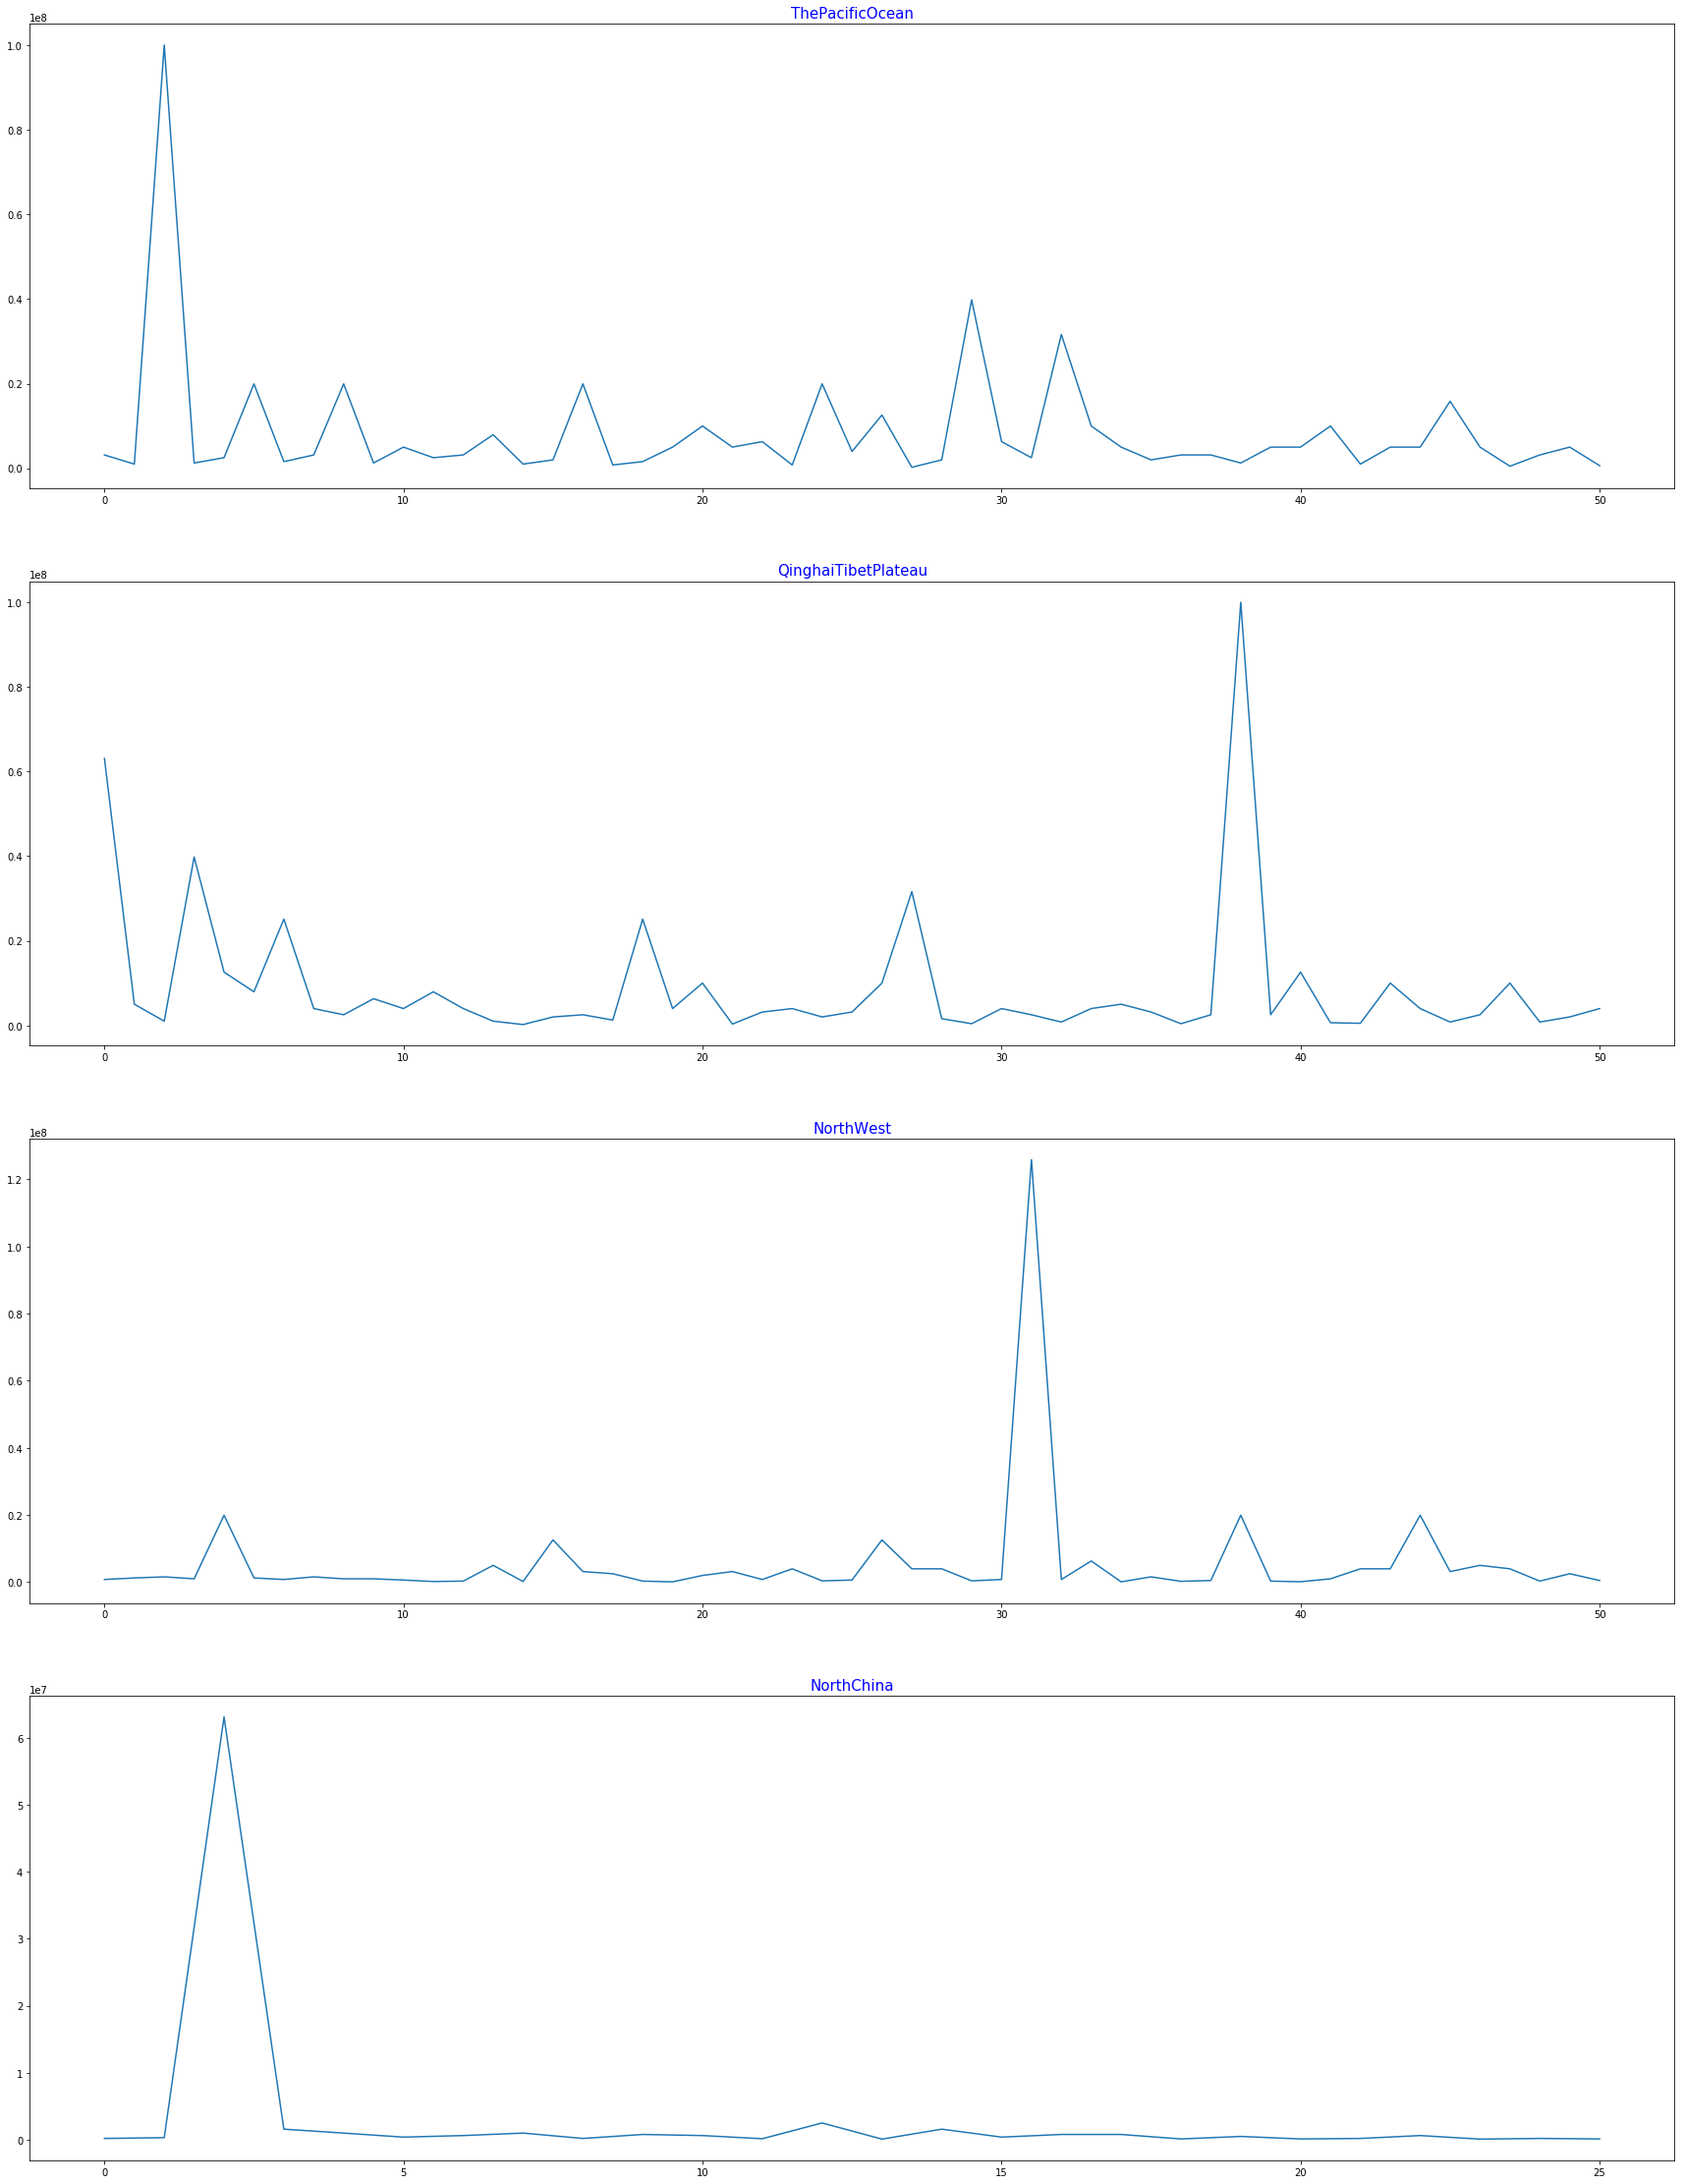

In [8]:
# 载入划分好的四个地震带数据（1970-2020），并可视化折线图
data_ThePacificOcean = read_data('./data/earthquake_year/ThePacificOcean.csv', 2, '震级')
data_QinghaiTibetPlateau = read_data('./data/earthquake_year/QinghaiTibetPlateau.csv', 2, '震级')
data_NorthWest = read_data('./data/earthquake_year/NorthWest.csv', 2, '震级')
data_NorthChina = read_data('./data/earthquake_year/NorthChina.csv', 2, '震级')
data_ThePacificOcean_energy = read_data('./data/earthquake_year/ThePacificOcean.csv', 3, '能量')
data_QinghaiTibetPlateau_energy  = read_data('./data/earthquake_year/QinghaiTibetPlateau.csv', 3, '能量')
data_NorthWest_energy  = read_data('./data/earthquake_year/NorthWest.csv', 3, '能量')
data_NorthChina_energy  = read_data('./data/earthquake_year/NorthChina.csv', 3, '能量')
print ("data_ThePacificOcean:%d"%len(data_ThePacificOcean))
print ("data_QinghaiTibetPlateau:%d"%len(data_QinghaiTibetPlateau)) 
print ("data_NorthWest:%d"%len(data_NorthWest)) 
print ("data_NorthChina:%d"%len(data_NorthChina)) 

show(data_ThePacificOcean,data_QinghaiTibetPlateau,data_NorthWest,data_NorthChina)
show(data_ThePacificOcean_energy,data_QinghaiTibetPlateau_energy,data_NorthWest_energy,data_NorthChina_energy)

### 3. 数据转化
- 采用时间窗方法划分数据，以使得时序预测问题可转换为传统的监督学习问题
- 转化为LSTM指定格式 [samples, time steps, features]

In [9]:
# 自定义多步预测的数据划分方法
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # 序列的结尾index
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # 检查是否越界
        if out_end_ix > len(sequence):
            break
        # 划分输入序列-X，输出序列-y
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
# 自定义数据预处理：数据划分 + 转化为时序神经网络指定格式 （样本个数，时间窗大小，输入的维度）
def data_pre(dataset, n_steps_in, n_steps_out):
    X, y = split_sequence(dataset, n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], 1)) 
    return X, y

In [11]:
# 选择时间窗口（输入步长，输出步长）
n_steps_in, n_steps_out = 10, 1

In [12]:
# 对四个地震带数据进行转化（震级）
X_tpo, y_tpo = data_pre(data_ThePacificOcean, n_steps_in, n_steps_out)
X_qtp, y_qtp = data_pre(data_QinghaiTibetPlateau, n_steps_in, n_steps_out)
X_nw, y_nw = data_pre(data_NorthWest, n_steps_in, n_steps_out)
X_nc, y_nc = data_pre(data_NorthChina, n_steps_in, n_steps_out)
# 对四个地震带数据进行转化（能量）
X_tpo_ey, y_tpo_ey = data_pre(data_ThePacificOcean_energy, n_steps_in, n_steps_out)
X_qtp_ey, y_qtp_ey = data_pre(data_QinghaiTibetPlateau_energy, n_steps_in, n_steps_out)
X_nw_ey, y_nw_ey = data_pre(data_NorthWest_energy, n_steps_in, n_steps_out)
X_nc_ey, y_nc_ey = data_pre(data_NorthChina_energy, n_steps_in, n_steps_out)
print(X_tpo.shape, y_tpo.shape)
print(X_qtp.shape, y_qtp.shape)
print(X_nw.shape, y_nw.shape)
print(X_nc.shape, y_nc.shape)

(41, 10, 1) (41, 1)
(41, 10, 1) (41, 1)
(41, 10, 1) (41, 1)
(16, 10, 1) (16, 1)


### 4. 构建Stacked LSTM、CNN、MLP模型分别进行多步预测

In [13]:
# Stacked LSTM
model1 = Sequential()
model1.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, 1))) # n_features取1
model1.add(LSTM(100, activation='relu'))
model1.add(Dense(n_steps_out))
model1.compile(optimizer='adam', loss='mse')
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# CNN
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, 1))) # n_features取1
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(n_steps_out))
model2.compile(optimizer='adam', loss='mse')
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9, 64)             192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                12850     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 13,093
Trainable params: 13,093
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# MLP
model3 = Sequential()
model3.add(Dense(64, activation='relu', input_shape=(n_steps_in, 1)))
model3.add(Dense(10, activation='softmax'))
model3.add(Flatten())
model3.add(Dense(50, activation='relu'))
model3.add(Dense(n_steps_out))
model3.compile(optimizer='adam', loss='mse')
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10, 64)            128       
_________________________________________________________________
dense_5 (Dense)              (None, 10, 10)            650       
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 5,879
Trainable params: 5,879
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# 模型训练(环太平洋-震级)
model1.fit(X_tpo, y_tpo, epochs=100,batch_size=20, verbose=2)
model2.fit(X_tpo, y_tpo, epochs=100,batch_size=20, verbose=2)
model3.fit(X_tpo, y_tpo, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 39.9224
Epoch 2/100
0s - loss: 32.7859
Epoch 3/100
0s - loss: 22.2415
Epoch 4/100
0s - loss: 4.6583
Epoch 5/100
0s - loss: 3.3495
Epoch 6/100
0s - loss: 1.1120
Epoch 7/100
0s - loss: 2.5238
Epoch 8/100
0s - loss: 1.3775
Epoch 9/100
0s - loss: 0.4933
Epoch 10/100
0s - loss: 2.4200
Epoch 11/100
0s - loss: 0.3312
Epoch 12/100
0s - loss: 1.3538
Epoch 13/100
0s - loss: 1.2277
Epoch 14/100
0s - loss: 0.3844
Epoch 15/100
0s - loss: 0.7302
Epoch 16/100
0s - loss: 0.3882
Epoch 17/100
0s - loss: 0.7676
Epoch 18/100
0s - loss: 0.4830
Epoch 19/100
0s - loss: 0.3776
Epoch 20/100
0s - loss: 0.5162
Epoch 21/100
0s - loss: 0.3104
Epoch 22/100
0s - loss: 0.3353
Epoch 23/100
0s - loss: 0.3375
Epoch 24/100
0s - loss: 0.3277
Epoch 25/100
0s - loss: 0.3920
Epoch 26/100
0s - loss: 0.4137
Epoch 27/100
0s - loss: 0.3132
Epoch 28/100
0s - loss: 0.3657
Epoch 29/100
0s - loss: 0.3052
Epoch 30/100
0s - loss: 0.3728
Epoch 31/100
0s - loss: 0.3290
Epoch 32/100
0s - loss: 0.3733
Epoch 33/100
0

Epoch 76/100
0s - loss: 0.2373
Epoch 77/100
0s - loss: 0.2379
Epoch 78/100
0s - loss: 0.2370
Epoch 79/100
0s - loss: 0.2352
Epoch 80/100
0s - loss: 0.2343
Epoch 81/100
0s - loss: 0.2337
Epoch 82/100
0s - loss: 0.2336
Epoch 83/100
0s - loss: 0.2339
Epoch 84/100
0s - loss: 0.2334
Epoch 85/100
0s - loss: 0.2332
Epoch 86/100
0s - loss: 0.2331
Epoch 87/100
0s - loss: 0.2329
Epoch 88/100
0s - loss: 0.2330
Epoch 89/100
0s - loss: 0.2328
Epoch 90/100
0s - loss: 0.2329
Epoch 91/100
0s - loss: 0.2329
Epoch 92/100
0s - loss: 0.2329
Epoch 93/100
0s - loss: 0.2331
Epoch 94/100
0s - loss: 0.2327
Epoch 95/100
0s - loss: 0.2328
Epoch 96/100
0s - loss: 0.2330
Epoch 97/100
0s - loss: 0.2326
Epoch 98/100
0s - loss: 0.2333
Epoch 99/100
0s - loss: 0.2335
Epoch 100/100
0s - loss: 0.2337


### 5. 模型预测

In [17]:
# 自定义预测
def pred(dataset, model):
    x_input = dataset[len(dataset)-n_steps_in:len(dataset)]
    x_input = x_input.reshape((1, n_steps_in, 1)) # n_features为1
    yhat = model.predict(x_input, verbose=0)
    y_pred = yhat.squeeze()
    return y_pred

In [18]:
# 根据震级预测2021年环太平洋地震带最大震级
y_pred1 = pred(data_ThePacificOcean, model1)
y_pred2 = pred(data_ThePacificOcean, model2)
y_pred3 = pred(data_ThePacificOcean, model3)
print(y_pred1)
print(y_pred2)
print(y_pred3)

5.8776317
6.777854
6.615907


In [19]:
# 模型训练(青藏高原-震级)
model1.fit(X_qtp, y_qtp, epochs=100,batch_size=20, verbose=2)
model2.fit(X_qtp, y_qtp, epochs=100,batch_size=20, verbose=2)
model3.fit(X_qtp, y_qtp, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 0.7307
Epoch 2/100
0s - loss: 0.5943
Epoch 3/100
0s - loss: 0.6366
Epoch 4/100
0s - loss: 0.4852
Epoch 5/100
0s - loss: 0.4604
Epoch 6/100
0s - loss: 0.4729
Epoch 7/100
0s - loss: 0.4706
Epoch 8/100
0s - loss: 0.4802
Epoch 9/100
0s - loss: 0.7050
Epoch 10/100
0s - loss: 0.8072
Epoch 11/100
0s - loss: 1.2339
Epoch 12/100
0s - loss: 0.5597
Epoch 13/100
0s - loss: 1.3548
Epoch 14/100
0s - loss: 0.7355
Epoch 15/100
0s - loss: 0.9075
Epoch 16/100
0s - loss: 0.5947
Epoch 17/100
0s - loss: 0.6558
Epoch 18/100
0s - loss: 0.5497
Epoch 19/100
0s - loss: 0.5411
Epoch 20/100
0s - loss: 0.6315
Epoch 21/100
0s - loss: 0.4724
Epoch 22/100
0s - loss: 0.4441
Epoch 23/100
0s - loss: 0.4753
Epoch 24/100
0s - loss: 0.6067
Epoch 25/100
0s - loss: 0.4178
Epoch 26/100
0s - loss: 0.5781
Epoch 27/100
0s - loss: 0.4618
Epoch 28/100
0s - loss: 0.4688
Epoch 29/100
0s - loss: 0.4436
Epoch 30/100
0s - loss: 0.4555
Epoch 31/100
0s - loss: 0.6594
Epoch 32/100
0s - loss: 0.6870
Epoch 33/100
0s -

Epoch 85/100
0s - loss: 0.3068
Epoch 86/100
0s - loss: 0.3056
Epoch 87/100
0s - loss: 0.3057
Epoch 88/100
0s - loss: 0.3065
Epoch 89/100
0s - loss: 0.3082
Epoch 90/100
0s - loss: 0.3083
Epoch 91/100
0s - loss: 0.3074
Epoch 92/100
0s - loss: 0.3061
Epoch 93/100
0s - loss: 0.3057
Epoch 94/100
0s - loss: 0.3062
Epoch 95/100
0s - loss: 0.3078
Epoch 96/100
0s - loss: 0.3091
Epoch 97/100
0s - loss: 0.3101
Epoch 98/100
0s - loss: 0.3121
Epoch 99/100
0s - loss: 0.3136
Epoch 100/100
0s - loss: 0.3134


In [20]:
# 根据震级预测2021年青藏高原地震带最大地震震级
y_pred1 = pred(data_QinghaiTibetPlateau, model1)
y_pred2 = pred(data_QinghaiTibetPlateau, model2)
y_pred3 = pred(data_QinghaiTibetPlateau, model3)
print(y_pred1)
print(y_pred2)
print(y_pred3)

6.7882385
6.466063
6.363258


In [21]:
# 模型训练(西北-震级)
model1.fit(X_nw, y_nw, epochs=100,batch_size=20, verbose=2)
model2.fit(X_nw, y_nw, epochs=100,batch_size=20, verbose=2)
model3.fit(X_nw, y_nw, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 0.7353
Epoch 2/100
0s - loss: 0.5550
Epoch 3/100
0s - loss: 0.5512
Epoch 4/100
0s - loss: 0.5470
Epoch 5/100
0s - loss: 0.5439
Epoch 6/100
0s - loss: 0.5681
Epoch 7/100
0s - loss: 0.6455
Epoch 8/100
0s - loss: 0.7918
Epoch 9/100
0s - loss: 0.5828
Epoch 10/100
0s - loss: 0.5244
Epoch 11/100
0s - loss: 0.5583
Epoch 12/100
0s - loss: 0.5941
Epoch 13/100
0s - loss: 0.5981
Epoch 14/100
0s - loss: 0.7893
Epoch 15/100
0s - loss: 0.5951
Epoch 16/100
0s - loss: 0.6595
Epoch 17/100
0s - loss: 0.9547
Epoch 18/100
0s - loss: 0.7652
Epoch 19/100
0s - loss: 0.5476
Epoch 20/100
0s - loss: 0.7241
Epoch 21/100
0s - loss: 0.7990
Epoch 22/100
0s - loss: 0.5329
Epoch 23/100
0s - loss: 0.5164
Epoch 24/100
0s - loss: 0.5144
Epoch 25/100
0s - loss: 0.5227
Epoch 26/100
0s - loss: 0.6326
Epoch 27/100
0s - loss: 0.5810
Epoch 28/100
0s - loss: 0.5050
Epoch 29/100
0s - loss: 0.5133
Epoch 30/100
0s - loss: 0.4954
Epoch 31/100
0s - loss: 0.4977
Epoch 32/100
0s - loss: 0.4974
Epoch 33/100
0s -

Epoch 71/100
0s - loss: 0.4947
Epoch 72/100
0s - loss: 0.4920
Epoch 73/100
0s - loss: 0.4890
Epoch 74/100
0s - loss: 0.4872
Epoch 75/100
0s - loss: 0.4869
Epoch 76/100
0s - loss: 0.4887
Epoch 77/100
0s - loss: 0.4886
Epoch 78/100
0s - loss: 0.4866
Epoch 79/100
0s - loss: 0.4865
Epoch 80/100
0s - loss: 0.4877
Epoch 81/100
0s - loss: 0.5011
Epoch 82/100
0s - loss: 0.5079
Epoch 83/100
0s - loss: 0.5065
Epoch 84/100
0s - loss: 0.5012
Epoch 85/100
0s - loss: 0.4954
Epoch 86/100
0s - loss: 0.4900
Epoch 87/100
0s - loss: 0.4865
Epoch 88/100
0s - loss: 0.4853
Epoch 89/100
0s - loss: 0.4899
Epoch 90/100
0s - loss: 0.4912
Epoch 91/100
0s - loss: 0.4904
Epoch 92/100
0s - loss: 0.4885
Epoch 93/100
0s - loss: 0.4861
Epoch 94/100
0s - loss: 0.4864
Epoch 95/100
0s - loss: 0.4873
Epoch 96/100
0s - loss: 0.4909
Epoch 97/100
0s - loss: 0.4960
Epoch 98/100
0s - loss: 0.4956
Epoch 99/100
0s - loss: 0.4929
Epoch 100/100
0s - loss: 0.4926


In [22]:
# 根据震级预测2021年西北地震带最大地震震级
y_pred1 = pred(data_NorthWest, model1)
y_pred2 = pred(data_NorthWest, model2)
y_pred3 = pred(data_NorthWest, model3)
print(y_pred1)
print(y_pred2)
print(y_pred3)

6.416458
7.0325565
6.2382298


In [23]:
# 模型训练（华北-震级）
model1.fit(X_nc, y_nc, epochs=100,batch_size=20, verbose=2)
model2.fit(X_nc, y_nc, epochs=100,batch_size=20, verbose=2)
model3.fit(X_nc, y_nc, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 0.8882
Epoch 2/100
0s - loss: 0.6934
Epoch 3/100
0s - loss: 0.4654
Epoch 4/100
0s - loss: 0.2874
Epoch 5/100
0s - loss: 0.1954
Epoch 6/100
0s - loss: 0.1844
Epoch 7/100
0s - loss: 0.2279
Epoch 8/100
0s - loss: 0.2945
Epoch 9/100
0s - loss: 0.3575
Epoch 10/100
0s - loss: 0.3995
Epoch 11/100
0s - loss: 0.4125
Epoch 12/100
0s - loss: 0.3972
Epoch 13/100
0s - loss: 0.3602
Epoch 14/100
0s - loss: 0.3115
Epoch 15/100
0s - loss: 0.2619
Epoch 16/100
0s - loss: 0.2206
Epoch 17/100
0s - loss: 0.1938
Epoch 18/100
0s - loss: 0.1840
Epoch 19/100
0s - loss: 0.1892
Epoch 20/100
0s - loss: 0.2043
Epoch 21/100
0s - loss: 0.2224
Epoch 22/100
0s - loss: 0.2371
Epoch 23/100
0s - loss: 0.2442
Epoch 24/100
0s - loss: 0.2424
Epoch 25/100
0s - loss: 0.2332
Epoch 26/100
0s - loss: 0.2198
Epoch 27/100
0s - loss: 0.2062
Epoch 28/100
0s - loss: 0.1951
Epoch 29/100
0s - loss: 0.1884
Epoch 30/100
0s - loss: 0.1863
Epoch 31/100
0s - loss: 0.1879
Epoch 32/100
0s - loss: 0.1917
Epoch 33/100
0s -

Epoch 85/100
0s - loss: 0.1858
Epoch 86/100
0s - loss: 0.1858
Epoch 87/100
0s - loss: 0.1857
Epoch 88/100
0s - loss: 0.1857
Epoch 89/100
0s - loss: 0.1857
Epoch 90/100
0s - loss: 0.1857
Epoch 91/100
0s - loss: 0.1857
Epoch 92/100
0s - loss: 0.1857
Epoch 93/100
0s - loss: 0.1857
Epoch 94/100
0s - loss: 0.1857
Epoch 95/100
0s - loss: 0.1857
Epoch 96/100
0s - loss: 0.1857
Epoch 97/100
0s - loss: 0.1857
Epoch 98/100
0s - loss: 0.1857
Epoch 99/100
0s - loss: 0.1857
Epoch 100/100
0s - loss: 0.1857


In [24]:
# 根据震级预测2021年华北地震带最大地震震级
y_pred1 = pred(data_NorthChina, model1)
y_pred2 = pred(data_NorthChina, model2)
y_pred3 = pred(data_NorthChina, model3)
print(y_pred1)
print(y_pred2)
print(y_pred3)

5.3880415
5.2247977
5.507973


In [25]:
# 模型训练(环太平洋-能量)
model1.fit(X_tpo_ey, y_tpo_ey, epochs=100,batch_size=20, verbose=2)
model2.fit(X_tpo_ey, y_tpo_ey, epochs=100,batch_size=20, verbose=2)
model3.fit(X_tpo_ey, y_tpo_ey, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 94053678819477.8594
Epoch 2/100
0s - loss: 85933297664799.2188
Epoch 3/100
0s - loss: 89902340348952.9688
Epoch 4/100
0s - loss: 83294796171214.0469
Epoch 5/100
0s - loss: 78297395210389.8594
Epoch 6/100
0s - loss: 66699919789805.2734
Epoch 7/100
0s - loss: 75437998073606.2344
Epoch 8/100
0s - loss: 74078047762881.5625
Epoch 9/100
0s - loss: 78033815607545.7656
Epoch 10/100
0s - loss: 77936797059421.6562
Epoch 11/100
0s - loss: 69913580353585.9531
Epoch 12/100
0s - loss: 72733575968418.3438
Epoch 13/100
0s - loss: 74977607865418.9219
Epoch 14/100
0s - loss: 78976963390389.0781
Epoch 15/100
0s - loss: 72100290973995.7031
Epoch 16/100
0s - loss: 75116860173636.6719
Epoch 17/100
0s - loss: 73113746039982.8281
Epoch 18/100
0s - loss: 73209279145734.2344
Epoch 19/100
0s - loss: 71868867693293.2812
Epoch 20/100
0s - loss: 72875129099338.9219
Epoch 21/100
0s - loss: 79496796106052.6719
Epoch 22/100
0s - loss: 70344229084584.5859
Epoch 23/100
0s - loss: 74863645300985.76

Epoch 17/100
0s - loss: 111540502518409.3594
Epoch 18/100
0s - loss: 111540478883889.9531
Epoch 19/100
0s - loss: 111540448398460.8750
Epoch 20/100
0s - loss: 111540440009852.8750
Epoch 21/100
0s - loss: 111540414383678.4219
Epoch 22/100
0s - loss: 111540395449368.9688
Epoch 23/100
0s - loss: 111540370152273.1719
Epoch 24/100
0s - loss: 111540357914024.5938
Epoch 25/100
0s - loss: 111540329979704.1875
Epoch 26/100
0s - loss: 111540309705103.6250
Epoch 27/100
0s - loss: 111540293311512.9688
Epoch 28/100
0s - loss: 111540276002016.7812
Epoch 29/100
0s - loss: 111540253171512.1875
Epoch 30/100
0s - loss: 111540227430250.1406
Epoch 31/100
0s - loss: 111540217225815.4062
Epoch 32/100
0s - loss: 111540181618987.7188
Epoch 33/100
0s - loss: 111540166050191.6250
Epoch 34/100
0s - loss: 111540145539022.0469
Epoch 35/100
0s - loss: 111540118276046.0469
Epoch 36/100
0s - loss: 111540110040888.1875
Epoch 37/100
0s - loss: 111540082573312.0000
Epoch 38/100
0s - loss: 111540067739797.8594
Epoch 39/1

In [26]:
# 根据能量预测2021年环太平洋地震带最大震级
y_pred1 = pred(data_ThePacificOcean_energy, model1)
y_pred2 = pred(data_ThePacificOcean_energy, model2)
y_pred3 = pred(data_ThePacificOcean_energy, model3)
y_pred1 = np.log10(y_pred1)
y_pred2 = np.log10(y_pred2)
y_pred3 = np.log10(y_pred3)
print(y_pred1)
print(y_pred2)
print(y_pred3)

6.2702966
6.1008425
2.2252238


In [27]:
# 模型训练(青藏高原-能量)
model1.fit(X_qtp_ey, y_qtp_ey, epochs=100,batch_size=20, verbose=2)
model2.fit(X_qtp_ey, y_qtp_ey, epochs=100,batch_size=20, verbose=2)
model3.fit(X_qtp_ey, y_qtp_ey, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 300406250981326.0625
Epoch 2/100
0s - loss: 291972578969949.6875
Epoch 3/100
0s - loss: 297067840952170.1250
Epoch 4/100
0s - loss: 284005340660111.6250
Epoch 5/100
0s - loss: 288504480242712.9375
Epoch 6/100
0s - loss: 285198930165360.3750
Epoch 7/100
0s - loss: 292885559061429.1250
Epoch 8/100
0s - loss: 280539325798649.7500
Epoch 9/100
0s - loss: 290890362153509.5000
Epoch 10/100
0s - loss: 292017596946282.1250
Epoch 11/100
0s - loss: 288616308660873.3750
Epoch 12/100
0s - loss: 282220503670184.5625
Epoch 13/100
0s - loss: 280709727889557.8438
Epoch 14/100
0s - loss: 278902612266908.0938
Epoch 15/100
0s - loss: 268379974258188.4688
Epoch 16/100
0s - loss: 266182536682920.5625
Epoch 17/100
0s - loss: 270937433731171.9062
Epoch 18/100
0s - loss: 250125225295872.0000
Epoch 19/100
0s - loss: 255423022871826.7188
Epoch 20/100
0s - loss: 277855410208368.3750
Epoch 21/100
0s - loss: 274718674786553.7500
Epoch 22/100
0s - loss: 250157062997966.0625
Epoch 23/100
0s - l

Epoch 1/100
0s - loss: 304535114299441.9375
Epoch 2/100
0s - loss: 304535134887336.5625
Epoch 3/100
0s - loss: 304535113608916.3125
Epoch 4/100
0s - loss: 304535045374751.2500
Epoch 5/100
0s - loss: 304535042043604.3125
Epoch 6/100
0s - loss: 304535027779134.4375
Epoch 7/100
0s - loss: 304534970209754.5000
Epoch 8/100
0s - loss: 304534968931003.3125
Epoch 9/100
0s - loss: 304534918118225.1875
Epoch 10/100
0s - loss: 304534847679812.6875
Epoch 11/100
0s - loss: 304534839298397.6875
Epoch 12/100
0s - loss: 304534798780366.0625
Epoch 13/100
0s - loss: 304534821698784.7500
Epoch 14/100
0s - loss: 304534814661257.3750
Epoch 15/100
0s - loss: 304534773179766.6250
Epoch 16/100
0s - loss: 304534704926420.3125
Epoch 17/100
0s - loss: 304534700111921.9375
Epoch 18/100
0s - loss: 304534681672329.3750
Epoch 19/100
0s - loss: 304534728711192.9375
Epoch 20/100
0s - loss: 304534688355402.8750
Epoch 21/100
0s - loss: 304534631366256.3750
Epoch 22/100
0s - loss: 304534626813902.0625
Epoch 23/100
0s - l

In [28]:
# 根据能量预测2021年青藏高原地震带最大地震震级
y_pred1 = pred(data_QinghaiTibetPlateau_energy, model1)
y_pred2 = pred(data_QinghaiTibetPlateau_energy, model2)
y_pred3 = pred(data_QinghaiTibetPlateau_energy, model3)
y_pred1 = np.log10(y_pred1)
y_pred2 = np.log10(y_pred2)
y_pred3 = np.log10(y_pred3)
print(y_pred1)
print(y_pred2)
print(y_pred3)

6.6664987
6.4698124
2.514174


In [29]:
# 模型训练(西北-能量)
model1.fit(X_nw_ey, y_nw_ey, epochs=100,batch_size=20, verbose=2)
model2.fit(X_nw_ey, y_nw_ey, epochs=100,batch_size=20, verbose=2)
model3.fit(X_nw_ey, y_nw_ey, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 368423472086640.3750
Epoch 2/100
0s - loss: 380900972388152.1875
Epoch 3/100
0s - loss: 386754552273145.7500
Epoch 4/100
0s - loss: 377376036829233.9375
Epoch 5/100
0s - loss: 356305538211240.5625
Epoch 6/100
0s - loss: 350585948413752.1875
Epoch 7/100
0s - loss: 352929211159227.3125
Epoch 8/100
0s - loss: 329437382494158.0625
Epoch 9/100
0s - loss: 364567437067438.8125
Epoch 10/100
0s - loss: 374686580949991.0625
Epoch 11/100
0s - loss: 286379428602055.8125
Epoch 12/100
0s - loss: 295382261067875.8750
Epoch 13/100
0s - loss: 326419725706215.0625
Epoch 14/100
0s - loss: 244704796613457.1875
Epoch 15/100
0s - loss: 245491519814880.7500
Epoch 16/100
0s - loss: 257741042917975.4375
Epoch 17/100
0s - loss: 373824954462307.8750
Epoch 18/100
0s - loss: 359690951043221.8750
Epoch 19/100
0s - loss: 329447361868675.1250
Epoch 20/100
0s - loss: 192545528498925.2500
Epoch 21/100
0s - loss: 236532198255541.0938
Epoch 22/100
0s - loss: 315143185446961.9375
Epoch 23/100
0s - l

0s - loss: 359298607055647.2500
Epoch 88/100
0s - loss: 363518832241589.1250
Epoch 89/100
0s - loss: 365891419290449.1875
Epoch 90/100
0s - loss: 367290921862318.8125
Epoch 91/100
0s - loss: 365093374848324.6875
Epoch 92/100
0s - loss: 359505644365174.6250
Epoch 93/100
0s - loss: 355095285078265.7500
Epoch 94/100
0s - loss: 352575909342133.1250
Epoch 95/100
0s - loss: 349523975045719.4375
Epoch 96/100
0s - loss: 349000732533735.0625
Epoch 97/100
0s - loss: 347551086069710.0625
Epoch 98/100
0s - loss: 346692117331968.0000
Epoch 99/100
0s - loss: 345357181108623.6250
Epoch 100/100
0s - loss: 344481017655395.8750
Epoch 1/100
0s - loss: 419543842828787.5000
Epoch 2/100
0s - loss: 419543852055976.5625
Epoch 3/100
0s - loss: 419543873416516.6875
Epoch 4/100
0s - loss: 419543798750232.9375
Epoch 5/100
0s - loss: 419543769118570.1250
Epoch 6/100
0s - loss: 419543741834614.6250
Epoch 7/100
0s - loss: 419543756666530.3125
Epoch 8/100
0s - loss: 419543756773825.5625
Epoch 9/100
0s - loss: 4195437

In [30]:
# 根据能量预测2021年西北地震带最大地震震级
y_pred1 = pred(data_NorthWest_energy, model1)
y_pred2 = pred(data_NorthWest_energy, model2)
y_pred3 = pred(data_NorthWest_energy, model3)
y_pred1 = np.log10(y_pred1)
y_pred2 = np.log10(y_pred2)
y_pred3 = np.log10(y_pred3)
print(y_pred1)
print(y_pred2)
print(y_pred3)

6.6003685
6.7458916
2.661981


In [31]:
# 模型训练（华北-能量）
model1.fit(X_nc_ey, y_nc_ey, epochs=100,batch_size=20, verbose=2)
model2.fit(X_nc_ey, y_nc_ey, epochs=100,batch_size=20, verbose=2)
model3.fit(X_nc_ey, y_nc_ey, epochs=100,batch_size=20, verbose=2)

Epoch 1/100
0s - loss: 3945724379136.0000
Epoch 2/100
0s - loss: 4125985079296.0000
Epoch 3/100
0s - loss: 4178133123072.0000
Epoch 4/100
0s - loss: 4666073546752.0000
Epoch 5/100
0s - loss: 5158668861440.0000
Epoch 6/100
0s - loss: 4814013464576.0000
Epoch 7/100
0s - loss: 4898659762176.0000
Epoch 8/100
0s - loss: 5003089543168.0000
Epoch 9/100
0s - loss: 6739110920192.0000
Epoch 10/100
0s - loss: 6631036813312.0000
Epoch 11/100
0s - loss: 10555453603840.0000
Epoch 12/100
0s - loss: 8592067919872.0000
Epoch 13/100
0s - loss: 8300262326272.0000
Epoch 14/100
0s - loss: 8096924041216.0000
Epoch 15/100
0s - loss: 7398241075200.0000
Epoch 16/100
0s - loss: 7319655546880.0000
Epoch 17/100
0s - loss: 2676051148800.0000
Epoch 18/100
0s - loss: 2313542434816.0000
Epoch 19/100
0s - loss: 6349244596224.0000
Epoch 20/100
0s - loss: 10615805444096.0000
Epoch 21/100
0s - loss: 11197214621696.0000
Epoch 22/100
0s - loss: 11033607405568.0000
Epoch 23/100
0s - loss: 10811706703872.0000
Epoch 24/100
0s

Epoch 19/100
0s - loss: 715828232192.0000
Epoch 20/100
0s - loss: 715828101120.0000
Epoch 21/100
0s - loss: 715828035584.0000
Epoch 22/100
0s - loss: 715827904512.0000
Epoch 23/100
0s - loss: 715827838976.0000
Epoch 24/100
0s - loss: 715827773440.0000
Epoch 25/100
0s - loss: 715827707904.0000
Epoch 26/100
0s - loss: 715827576832.0000
Epoch 27/100
0s - loss: 715827576832.0000
Epoch 28/100
0s - loss: 715827576832.0000
Epoch 29/100
0s - loss: 715827511296.0000
Epoch 30/100
0s - loss: 715827380224.0000
Epoch 31/100
0s - loss: 715827314688.0000
Epoch 32/100
0s - loss: 715827249152.0000
Epoch 33/100
0s - loss: 715827183616.0000
Epoch 34/100
0s - loss: 715827183616.0000
Epoch 35/100
0s - loss: 715827183616.0000
Epoch 36/100
0s - loss: 715827052544.0000
Epoch 37/100
0s - loss: 715826987008.0000
Epoch 38/100
0s - loss: 715826987008.0000
Epoch 39/100
0s - loss: 715826921472.0000
Epoch 40/100
0s - loss: 715826921472.0000
Epoch 41/100
0s - loss: 715826855936.0000
Epoch 42/100
0s - loss: 7158267904

In [32]:
# 根据能量预测2021年华北地震带最大地震震级
y_pred1 = pred(data_NorthChina_energy, model1)
y_pred2 = pred(data_NorthChina_energy, model2)
y_pred3 = pred(data_NorthChina_energy, model3)
y_pred1 = np.log10(y_pred1)
y_pred2 = np.log10(y_pred2)
y_pred3 = np.log10(y_pred3)
print(y_pred1)
print(y_pred2)
print(y_pred3)

4.8219204
5.674778
2.6682506
